<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 4: Energy-based Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

This homework helps you implement a Energy-based Model (EBM).  
For references please refer to the original [Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689).

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* Feel free to change any part of notebook, but remeber to use comments for clarification.
* You can get **complete score** for this notebook if your codes work properly and without errors.
* This notebook is tested with *Google Colab*.

In [ ]:
Name = "fariborz kohanzad"
StudentId = "400103613"

# Energy-based Models (EBMs) (80 pts)

## Introduction

In this notebook, we will look at energy-based deep learning models, and focus on their application as generative models.

First, let's import our libraries below.

In [2]:
# Standard libraries
import numpy as np
import random
from tqdm import tqdm

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid

device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Energy Models

As we have seen in the class, Energy-based models tend to predict probability density distribution. For this purpose we need to learn given probability:



$p_{\theta }( x_{train}) =\frac{e^{f_{\theta }( x)}}{Z( \theta )}$



Here $p_{\theta }( x_{train})$ stands for probability density of our training data distribution. We know that calculating the partition function ($Z( \theta )$) is interactable. For this purpose we will use contrastive divergence algorithm.

### Contrastive Divergence

We train generative models usually by maximum likelihood estimation. But the exact likelihood of a point cannot be determined due to intractable normalization constant $Z(\theta)$, we need to train energy-based models slightly different. We can re-write our maximum likelihood objective where we maximize the probability of $\mathbf{x}_{\text{train}}$ compared to a randomly sampled data point of our model:

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta}) & = \nabla_{\theta}\log p_{\theta}(\mathbf{x})\\[5pt]
    & \approx  \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{train}}}) - \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{sample}}})
\end{split}
$$

Note that the loss is still an objective we want to minimize. Thus, we try to minimize the energy for data points from the dataset, while maximizing the energy for randomly sampled data points from our model. The trick for sampling is that we approximate $Z(\theta)$ by a single Monte-Carlo sample. This gives us the exact same objective as written above.

Visually, the objective is shown below (figure - [Stefano Ermon and Aditya Grover](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture11.pdf)):


<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/contrastive_divergence.svg" width="90%"></center>


The point on the right, called "correct answer", represents a data point from the dataset (i.e. $x_{\text{train}}$), and the left point, "wrong answer", a sample from our model (i.e. $x_{\text{sample}}$). Thus, we try to "pull up" the probability of the data points in the dataset, while "pushing down" randomly sampled points.

### Dataset

First, we load the MNIST dataset below. Note that we need to normalize the images between -1 and 1 instead of mean 0 and std 1 because during sampling, we have to limit the input space. Scaling between -1 and 1 makes it easier to implement it.

In [3]:
############ TODO #############:
BATCH_SIZE = 64

transform =  transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])
###############################

train_set = MNIST(root='./', train=True, transform=transform, download=True)
test_set = MNIST(root='./', train=False, transform=transform, download=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Failed to download (trying next):
<urlopen error [Errno -5] No address associated with hostname>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.4MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 345kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:04<00:00, 386kB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.30MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



### CNN Model

First, we implement our CNN model. The MNIST images are 28x28, hence a small model is enough. But you are free to use pre-trained Convolution Networks (such as Resnet, etc.)

Here we use a smooth activation function like Swish instead of ReLU in the energy model. This is because gradients should not be sparse.

In [4]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1):
        super(CNNModel, self).__init__()
        ############ TODO #############:
        # Define hidden layers (Conv) in and out dimensions
        hidden_dim_1 =  hidden_features//2
        hidden_dim_2 =  hidden_features
        hidden_dim_3 =  hidden_features*2
        ################################

        # Series of convolutions and Swish activation functions
        # your're free to implement any CNN Network. You can also use pretrained networks (like ResNet, etc.) instead.
        ############ TODO #############:
        self.cnn_net = nn.Sequential(
                nn.Conv2d(1, hidden_dim_1, kernel_size=5, stride=2, padding=4), # [16x16] - Larger padding to get 32x32 image
                Swish(),
                nn.Conv2d(hidden_dim_1, hidden_dim_2, kernel_size=3, stride=2, padding=1), #  [8x8]
                Swish(),
                nn.Conv2d(hidden_dim_2, hidden_dim_3, kernel_size=3, stride=2, padding=1), # [4x4]
                Swish(),
                nn.Conv2d(hidden_dim_3, hidden_dim_3, kernel_size=3, stride=2, padding=1), # [2x2]
                Swish(),
                nn.Flatten(),
                nn.Linear(hidden_dim_3*4, hidden_dim_3),
                Swish(),
                nn.Linear(hidden_dim_3, out_dim)
        )
        ################################

    def forward(self, x):
        # Feed the input to the network and return the output
        ############ TODO #############:
        x = self.cnn_net(x).squeeze(dim=-1)
        return x
        ################################

### Sampling buffer

In this part, we construct our sampler. To use the contrastive divergence objective, we need to generate samples during training. The simple way to sampling is to use simple MCMC algorithm, but in practice it costs too much. So here we use *Langevin MCMC* that uses gradient for better sampling.

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/sampling.svg" width="90%"></center>

Below, we implement the sampling class. The function `sample_new_exmps` returns a new batch of "fake" images . These images are generated using MCMC. For more efficiency, each time we only generate 5% of sample size and other 95% are randomly picked from our buffer. We perform MCMC for 80 iterations to improve the image quality and come closer to samples from $p_{\theta}(\mathbf{x})$. In the function `generate_samples`, we implemented the MCMC for images. Note that the hyperparameters in this code are for MNIST dataset.

In [5]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape) * 2 - 1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        # Only generate 5% of sample size and use other 95% from buffer (examples)
        # You can generate samples the same way they're generated in "examples"
        # Then randomly choose 95% of sample size from examples and add newly generated one to it
        ############ TODO #############:
        n_new = np.random.binomial(self.sample_size, 0.05)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1
        old_imgs = torch.cat(random.choices(self.examples, k=self.sample_size-n_new), dim=0)
        newly_imgs = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(device)
        ################################

        # Perform MCMC sampling (use generate_samples)
        ############ TODO #############:
        newly_imgs =  Sampler.generate_samples(self.model, newly_imgs, steps=steps, step_size=step_size)
        ################################

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(newly_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]
        return newly_imgs

    @staticmethod
    def generate_samples(model, newly_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            newly_imgs - Images to start from for sampling. If you want to generate new images.
            steps - Number of iterations in the Langevin MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        is_training = model.training
        model.eval()
        for p in model.parameters():
            p.requires_grad = False
        newly_imgs.requires_grad = True

        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # we use a buffer tensor in which we generate noise each loop iteration.
        # more efficient than creating a new tensor every iteration.
        # generate random tensor using image shape
        ############ TODO #############:
        noise = torch.randn(newly_imgs.shape, device=newly_imgs.device)
        ################################

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        for _ in range(steps):
            # You can use tensor functions to complete the code. eg. tensor.add, tensor.grad

            # Part 1:
            # Sample noise tensor data from a normal dist (mu=0, std=0.005).
            # Add the noise to the new image
            # Clamp it between -1 and 1
            ############ TODO #############:
            noise.normal_(0, 0.005)
            newly_imgs.data.add_(noise.data)
            newly_imgs.data.clamp_(min=-1.0, max=1.0)
            ################################


            # Part 2:
            # Feed new image to the model (**model output sign is important)
            # Use backward on sum of output to calculate gradient
            # Clamp tensor gradient between -0.05 and 0.05 (preventing too high gradients)
            ############ TODO #############:
            out_imgs = -model(newly_imgs)
            out_imgs.sum().backward()
            newly_imgs.grad.data.clamp_(-0.05, 0.05)
            ################################

            # Part 3:
            # Add grad to the image with step_size (like the given algorithm)
            ############ TODO #############:
            newly_imgs.data.add_(-step_size * newly_imgs.grad.data)
            ################################
            newly_imgs.grad.detach_()
            newly_imgs.grad.zero_()
            newly_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(newly_imgs.clone().detach())

        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)

        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return newly_imgs

### Training algorithm

Below is shown a summary of the full training algorithm of an energy model:

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/training_algorithm.svg" width="80%"></center>

Given algorithm, for each batch of data we're going to, first, add a small noise to image, then we sample a fake image using `sample_new_example`. After this we feed these images to our `Model`. At the end we use our `ebm_loss` to calculate loss and backward to complete our trainig.

For evaluation we use almost the same structure as our training, but with a different loss.

After training phase we're going to use `generate_image` to sample from our model (generate images).

In [45]:
def train_one_epoch(model, train_loader, optimizer, sampler, alpha):
    """
    Input:
        model: implemented CNN
        train_loader: train Dataloader
        optimizer: Optimizer to optimize model
        sampler: Sampler to generate samples
        alpha: hyperparameter for loss
    Returns:
        float: Epoch loss
    """
    model.train()
    epoch_loss = 0

    for real_imgs, _ in tqdm(train_loader, desc="Training Progress"):
        # Add minimal noise to the real images
        noise = torch.randn_like(real_imgs) * 0.005
        real_imgs = real_imgs + noise
        real_imgs.clamp_(-1.0, 1.0)

        # Generate fake images using the sampler
        fake_imgs = sampler.sample_new_exmps(steps=80, step_size=10)

        # Concatenate real and fake images and compute the model's output
        real_imgs, fake_imgs = real_imgs.to(device), fake_imgs.to(device)
        all_imgs = torch.cat([real_imgs, fake_imgs], dim=0)
        real_out, fake_out = model(all_imgs).chunk(2, dim=0)

        # Compute the loss using energy-based loss
        loss = ebm_loss(real_out, fake_out, alpha)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track epoch loss
        epoch_loss += loss.item()

    return epoch_loss / len(train_loader)


def test_one_epoch(model, test_loader):
    """
    Validates the model using contrastive divergence between random and real images.
    Input:
        model: CNN to evaluate
        test_loader: DataLoader for the validation set
    Returns:
        float: Average contrastive divergence over the test set
    """
    model.eval()
    total_cdiv = 0

    with torch.no_grad():
        for real_imgs, _ in tqdm(test_loader, desc="Validation Progress"):
            # Move real images to device
            real_imgs = real_imgs.to(device)

            # Generate random fake images
            fake_imgs = torch.rand_like(real_imgs) * 2 - 1

            # Compute model outputs for real and fake images
            real_out = model(real_imgs)
            fake_out = model(fake_imgs)

            # Calculate contrastive divergence
            total_cdiv += (fake_out.mean() - real_out.mean()).item()

    return total_cdiv / len(test_loader)


def generate_image(model, sampler, sample_size, steps=256, step_size=0.01):
    """
    Input:
        model: implemented CNN
        sampler: instance of Sampler class
        sample_size: number of samples to generate
        steps: number of Langevin steps for each sample generation
        step_size: step size for Langevin dynamics
    Returns:
        torch.Tensor: Generated images of shape [sample_size, *img_shape]
    """
    # Ensure the model is in evaluation mode
    model.eval()

    # Store all generated samples
    generated_samples = []
    start_imgs = (torch.rand((1,)+(1, 28, 28))*2-1).to(device)
    # Generate the required number of samples
    with tqdm(range(sample_size), desc="Generating Samples") as pbar:
        for _ in pbar:
            # Use sampler to get the newest samples
            newest_sample = sampler.generate_samples(model, start_imgs, steps=300, step_size=10, return_img_per_step=False)

            generated_samples.append(newest_sample[0])  # Append the first sample

    # Stack all samples into a tensor
    return torch.stack(generated_samples, dim=0)



### Loss

Here we define our Energy-based Model loss. EBM loss consist of two different losses.


1.   Contrastive divergence using our energy model $f_{\theta}$
2.   Regularization term is additional training trick to ensure that the output values are in a reasonable range. Without this regularization loss, the output values will fluctuate in a very large range

`alpha` is a hyperparameter for regularization term ($\alpha<1$)

In [7]:
# Implement the given EBM loss
############ TODO #############:
def ebm_loss(real, fake, alpha):
    reg_loss = alpha * (real ** 2 + fake ** 2).mean()
    cdiv_loss = fake.mean() - real.mean()

    # Total EBM loss
    loss = reg_loss +  cdiv_loss

    return loss
################################

### Instantiation

Instantiat your **Model**, **Sampler** and **Optimizer**.

In [8]:
lr = 1e-4  # Learning rate
alpha = 0.1  # Regularization weight (should be less than 1)
img_shape = (1, 28, 28)

model = CNNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
sampler = Sampler(model, img_shape, BATCH_SIZE)

### Train Loop

Train your model and print loss for each epoch.

In [9]:
train_loss = []
epoch = 20

for i in range(epoch):
    print(f'Epoch {i+1}: ')

    # Train for one epoch
    epoch_loss = train_one_epoch(model, train_loader, optimizer, sampler, alpha)
    train_loss.append(epoch_loss)
    print(f'Train Loss = {train_loss[-1]:.4f}')

    # Compute Contrastive Divergence on the test set
    test_cdiv = test_one_epoch(model, test_loader)
    print(f"Test Contrastive Divergence: {test_cdiv:.4f}")


Epoch 1: 


Training Progress: 100%|██████████| 937/937 [02:42<00:00,  5.77it/s]


Train Loss = -0.0083


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 69.33it/s]


Test Contrastive Divergence: -1.0352
Epoch 2: 


Training Progress: 100%|██████████| 937/937 [02:45<00:00,  5.66it/s]


Train Loss = -0.0005


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 60.82it/s]


Test Contrastive Divergence: -1.9030
Epoch 3: 


Training Progress: 100%|██████████| 937/937 [02:39<00:00,  5.86it/s]


Train Loss = 0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 71.92it/s]


Test Contrastive Divergence: -2.2598
Epoch 4: 


Training Progress: 100%|██████████| 937/937 [02:39<00:00,  5.89it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 71.76it/s]


Test Contrastive Divergence: -2.8029
Epoch 5: 


Training Progress: 100%|██████████| 937/937 [02:38<00:00,  5.92it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 72.35it/s]


Test Contrastive Divergence: -3.2440
Epoch 6: 


Training Progress: 100%|██████████| 937/937 [02:39<00:00,  5.87it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 70.31it/s]


Test Contrastive Divergence: -3.8645
Epoch 7: 


Training Progress: 100%|██████████| 937/937 [02:37<00:00,  5.94it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 71.60it/s]


Test Contrastive Divergence: -4.4764
Epoch 8: 


Training Progress: 100%|██████████| 937/937 [02:41<00:00,  5.80it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 54.50it/s]


Test Contrastive Divergence: -5.2052
Epoch 9: 


Training Progress: 100%|██████████| 937/937 [02:36<00:00,  6.00it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 56.39it/s]


Test Contrastive Divergence: -5.6404
Epoch 10: 


Training Progress: 100%|██████████| 937/937 [02:36<00:00,  5.99it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 54.05it/s]


Test Contrastive Divergence: -6.4643
Epoch 11: 


Training Progress: 100%|██████████| 937/937 [02:36<00:00,  5.99it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 56.21it/s]


Test Contrastive Divergence: -7.2463
Epoch 12: 


Training Progress: 100%|██████████| 937/937 [02:35<00:00,  6.02it/s]


Train Loss = 0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 74.14it/s]


Test Contrastive Divergence: -7.7747
Epoch 13: 


Training Progress: 100%|██████████| 937/937 [02:34<00:00,  6.05it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 73.16it/s]


Test Contrastive Divergence: -8.2266
Epoch 14: 


Training Progress: 100%|██████████| 937/937 [02:35<00:00,  6.03it/s]


Train Loss = 0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 73.46it/s]


Test Contrastive Divergence: -8.8016
Epoch 15: 


Training Progress: 100%|██████████| 937/937 [02:34<00:00,  6.08it/s]


Train Loss = 0.0000


Validation Progress: 100%|██████████| 157/157 [00:01<00:00, 79.00it/s]


Test Contrastive Divergence: -9.3895
Epoch 16: 


Training Progress: 100%|██████████| 937/937 [02:35<00:00,  6.02it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 73.58it/s]


Test Contrastive Divergence: -9.9450
Epoch 17: 


Training Progress: 100%|██████████| 937/937 [02:33<00:00,  6.10it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 75.39it/s]


Test Contrastive Divergence: -10.3627
Epoch 18: 


Training Progress: 100%|██████████| 937/937 [02:32<00:00,  6.15it/s]


Train Loss = -0.0000


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 77.90it/s]


Test Contrastive Divergence: -11.0203
Epoch 19: 


Training Progress: 100%|██████████| 937/937 [02:32<00:00,  6.16it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 64.80it/s]


Test Contrastive Divergence: -11.5433
Epoch 20: 


Training Progress: 100%|██████████| 937/937 [02:32<00:00,  6.13it/s]


Train Loss = -0.0001


Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 56.49it/s]

Test Contrastive Divergence: -11.7715


### Test
Test your Model using Test Dataloader

In [15]:
# Compute Contrastive Divergence on the test set
test_cdiv = test_one_epoch(model, test_loader)

# Display test result
print(f"Test Contrastive Divergence: {test_cdiv}")

Validation Progress: 100%|██████████| 157/157 [00:02<00:00, 66.11it/s]

Test Contrastive Divergence: -11.77379035949707


### Generate Image

Here you have to use `generate_image` to sample from model and visualize it.

In [17]:
def generate_images(pl_module):
    """
    Generates images per step using the given PyTorch Lightning module.
    Input:
        pl_module: PyTorch Lightning module used for sampling
    Returns:
        Tensor: Images generated at each step of the sampling process
    """
    # Set the module to evaluation mode
    pl_module.eval()

    # Initialize starting images with random noise in the range [-1, 1]
    start_imgs = (torch.rand((4,) + img_shape) * 2 - 1).to(device)

    # Enable gradient tracking (necessary for Langevin MCMC sampling)
    torch.set_grad_enabled(True)

    # Generate images for each step
    imgs_per_step = sampler.generate_samples(
        pl_module, start_imgs, steps=257, step_size=10, return_img_per_step=True
    )

    # Disable gradient tracking and return to training mode
    torch.set_grad_enabled(False)
    pl_module.train()

    return imgs_per_step

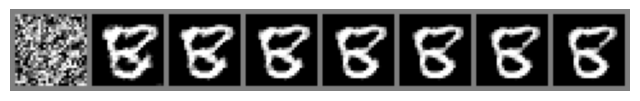

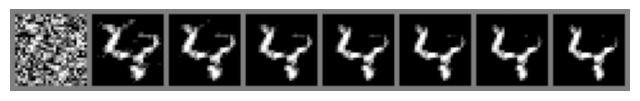

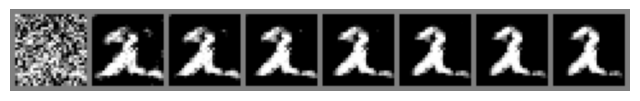

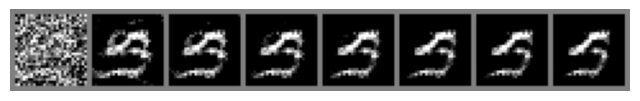

In [43]:
# Generate images and move them to CPU
imgs_per_step = generate_images(model).cpu()

# Iterate through each step of the image generation process
for step in range(imgs_per_step.shape[1]):
    # Select images to plot at specific intervals
    imgs_to_plot = imgs_per_step[0:256:32, step]

    # Create a grid of images
    grid = torchvision.utils.make_grid(
        imgs_to_plot,
        nrow=imgs_to_plot.shape[0],
        normalize=True,
        pad_value=0.5,
        padding=2
    )

    # Prepare the grid for display
    grid = grid.permute(1, 2, 0).cpu()

    # Plot the grid of images
    plt.figure(figsize=(8, 8))
    plt.imshow(grid)
    plt.xlabel("Generation iteration")
    plt.axis('off')  # Turn off axis for cleaner visualization
    plt.show()


# Evaluation (20 pts)

Now lets evaluate the model more precisely.

In [13]:
from scipy.spatial import distance

def compute_entropy(labels):
      """
      Compute entropy of the given labels.

      Args:
          labels: input labels (non-negative integers)

      Returns:
          entropy: computed entropy
      """
      # Ensure all labels are non-negative
      labels = np.array(labels)
      if np.min(labels) < 0:
          labels -= np.min(labels)  # Shift all values to be non-negative

      value_counts = np.bincount(labels)  # Count occurrences of each label
      probabilities = value_counts / np.sum(value_counts)  # Compute probabilities
      probabilities = probabilities[probabilities > 0]  # Filter out zero probabilities
      entropy = -np.sum(probabilities * np.log(probabilities))  # Compute entropy
      return entropy

def compute_identifiability(orig_data, synth_data):
    """
    Args:
        orig_data: original data
        synth_data: synthetically generated data

    Returns:
        identifiability_value: Identifiability value
    """
    orig_data = np.asarray(orig_data)
    synth_data = np.asarray(synth_data)

    no, x_dim = np.shape(orig_data)
    W = np.zeros([x_dim,])

    # Compute weights
    for i in range(x_dim):
        labels = np.round(orig_data[:, i] * 100).astype(int)
        if np.min(labels) < 0:
            labels -= np.min(labels)
        W[i] = compute_entropy(labels)
    W = W / np.sum(W)

    # Normalize using weights
    orig_data_hat = orig_data * W
    synth_data_hat = synth_data * W

    # Compute distances
    orig_distances = distance.cdist(orig_data_hat, orig_data_hat, metric="euclidean")
    np.fill_diagonal(orig_distances, np.inf)
    nearest_orig = np.sort(orig_distances, axis=1)[:, :2]

    synth_distances = distance.cdist(orig_data_hat, synth_data_hat, metric="euclidean")
    nearest_synth = np.min(synth_distances, axis=1)

    # Compute identifiability metric
    differences = nearest_synth - nearest_orig[:, 1]
    negative_differences = np.sum(differences < 0)
    identifiability_value = negative_differences / len(orig_data)

    return identifiability_value

In [46]:
# Limit the number of samples to 1024
MAX_SAMPLES = 1024

origin_data = []
for img, _ in test_loader:
    origin_data.append(img.numpy())
    if len(origin_data) * img.size(0) >= MAX_SAMPLES:
        break

origin_data = np.concatenate(origin_data, axis=0)

origin_data = origin_data.reshape(-1, 28*28)

synth_data = []
for i in range(MAX_SAMPLES // BATCH_SIZE):
    print(i)
    img = generate_image(model, sampler ,BATCH_SIZE).squeeze().cpu().detach().numpy()
    synth_data.append(img)

synth_data = np.concatenate(synth_data, axis=0)

synth_data = synth_data.reshape(-1, 28*28)

0


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.03it/s]


1


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.95it/s]


2


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


3


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


4


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.97it/s]


5


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  2.00it/s]


6


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.01it/s]


7


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.04it/s]


8


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.96it/s]


9


Generating Samples: 100%|██████████| 64/64 [00:33<00:00,  1.93it/s]


10


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.02it/s]


11


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.00it/s]


12


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.04it/s]


13


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.01it/s]


14


Generating Samples: 100%|██████████| 64/64 [00:31<00:00,  2.04it/s]


15


Generating Samples: 100%|██████████| 64/64 [00:32<00:00,  1.99it/s]


In [47]:
identifiability_value = compute_identifiability(origin_data, synth_data)
print(identifiability_value)

0.01171875


## Showing generations

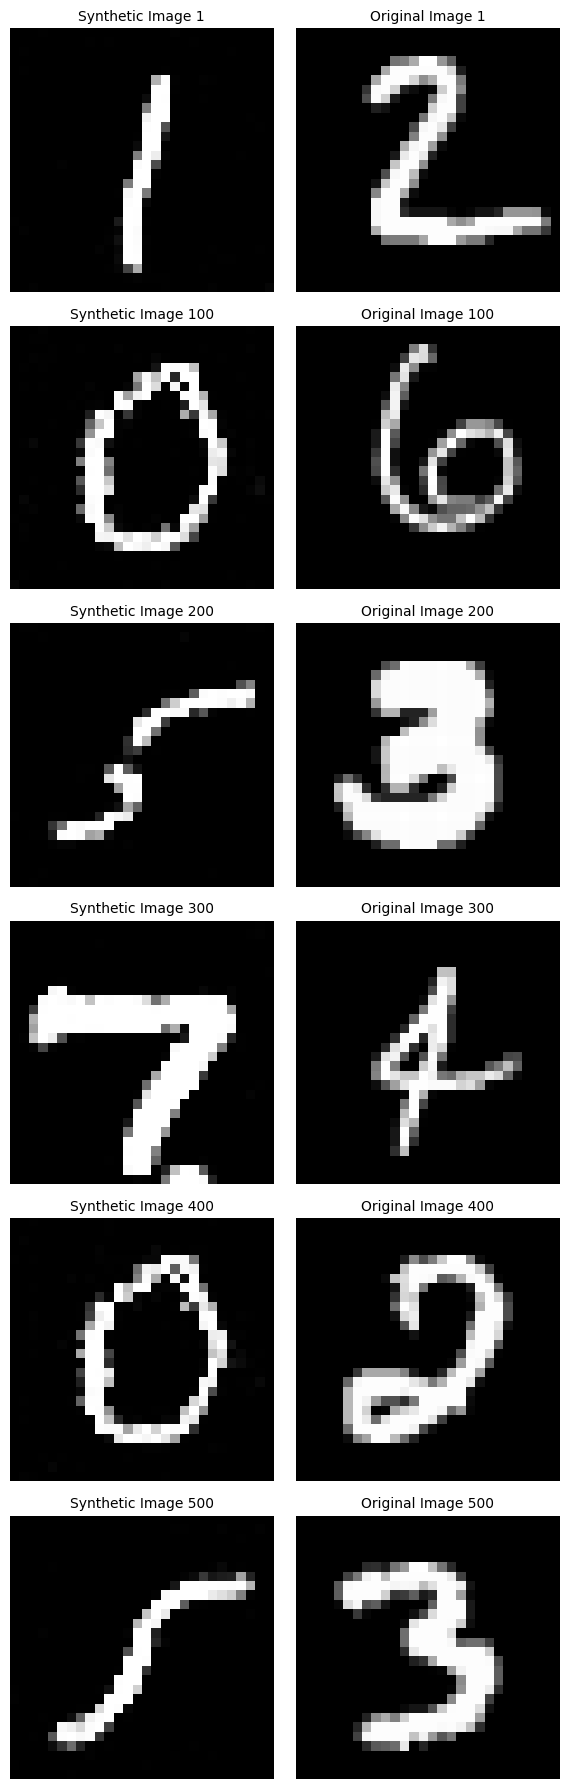

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples to plot
k = 6

# Generate random indices to select images
indices = (1, 100, 200, 300, 400, 500)

# Create a figure
fig, axes = plt.subplots(k, 2, figsize=(6, 3*k))

# Plot the images
for i, idx in enumerate(indices):
    # Synthetic image (left side)
    axes[i, 0].imshow(synth_data[idx].reshape(28, 28), cmap='gray')
    axes[i, 0].axis('off')  # Turn off axis
    axes[i, 0].set_title(f"Synthetic Image {idx}", fontsize=10)

    # Original image (right side)
    axes[i, 1].imshow(origin_data[idx].reshape(28, 28), cmap='gray')
    axes[i, 1].axis('off')  # Turn off axis
    axes[i, 1].set_title(f"Original Image {idx}", fontsize=10)

plt.tight_layout()
plt.show()
